# (E6) 작사가 만들기

## 데이터 로드

In [1]:
import glob
import os
import re
import tensorflow as tf
import numpy as np     
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Now greetings to the world! Standing at this liquor store,', 'Whiskey coming through my pores,', 'Feeling like I run this whole block.']


In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

# print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

In [3]:
import re
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> now greetings to the world ! standing at this liquor store , <end>',
 '<start> whiskey coming through my pores , <end>',
 '<start> feeling like i run this whole block . <end>',
 '<start> lotto tickets cheap beer <end>',
 '<start> that s why you can catch me here , <end>',
 '<start> tryna scratch my way up to the top . cause my job got me going nowhere , <end>',
 '<start> so i ain t got a thing to lose . <end>',
 '<start> take me to a place where i don t care , <end>',
 '<start> this is me and my liquor store blues . i ll take one shot for my pain , <end>',
 '<start> one drag for my sorrow . <end>']

In [4]:
import tensorflow as tf

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    a =[]
    for i in tensor:    
        if len(i) < 16:
            a.append(i)
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(a, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50 5041 ...    4    3    0]
 [   2 2757  286 ...    0    0    0]
 [   2  331   25 ...    0    0    0]
 ...
 [   2    5   33 ...    0    0    0]
 [   2    5   33 ...   13  169    3]
 [   2    5  373 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f436ba65950>


In [5]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2   50 5041   10    6  143   59  581   71   42 1372 1043    4    3]
[  50 5041   10    6  143   59  581   71   42 1372 1043    4    3    0]


In [6]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True)

In [ ]:
print(enc_train.shape)

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
# len(tokenizer.index_word)
vocab_size = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)



In [10]:
print(train_dataset)
print(val_dataset)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


In [11]:
from tensorflow import keras
embedding_size = 256
hidden_size = 1024

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,embedding_size, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(hidden_size,return_sequences = True))
model.add(tf.keras.layers.LSTM(hidden_size,return_sequences = True))
model.add(tf.keras.layers.Dense(vocab_size))




In [ ]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         3072256   
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        5246976   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dense (Dense)                (None, None, 12001)       12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
model.compile(loss = loss,optimizer=optimizer)
history = model.fit(train_dataset,validation_data = val_dataset,epochs = 10)

Epoch 1/10
487/487 [==============================] - 64s 131ms/step - loss: 3.4898 - val_loss: 3.1420
Epoch 2/10
487/487 [==============================] - 66s 135ms/step - loss: 3.0233 - val_loss: 2.9617
Epoch 3/10
487/487 [==============================] - 66s 135ms/step - loss: 2.8610 - val_loss: 2.8494
Epoch 4/10
487/487 [==============================] - 65s 134ms/step - loss: 2.7386 - val_loss: 2.7716
Epoch 5/10
487/487 [==============================] - 65s 134ms/step - loss: 2.6364 - val_loss: 2.7123
Epoch 6/10
487/487 [==============================] - 67s 139ms/step - loss: 2.5442 - val_loss: 2.6625
Epoch 7/10
487/487 [==============================] - 68s 140ms/step - loss: 2.4590 - val_loss: 2.6196
Epoch 8/10
487/487 [==============================] - 67s 137ms/step - loss: 2.3787 - val_loss: 2.5832
Epoch 9/10
487/487 [==============================] - 69s 142ms/step - loss: 2.3024 - val_loss: 2.5533
Epoch 10/10
487/487 [==============================] - 69s 142ms/step - l

dict_keys(['loss', 'val_loss'])


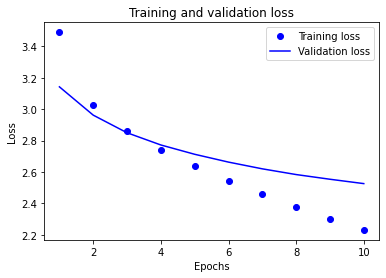

In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, 11)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [27]:
predic_word.numpy()[0]

NameError: name 'predic_word' is not defined

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you <end> '